# Homework 17

Each of the problems below requires you to **combine** Python programming concepts from previous homeworks and to perform proper **units conversion**.  

In [1]:
from all_imports import *

### Problem 1 (3 points) 

(Continuation of HW 16 Problem 1.)

Your task is to **estimate** and **plot** the pressure drop $\Delta P$ across a horizontal section of pipe as a function of volumetric flowrate $Q$ through the pipe. This is something you might do in ChEn 374. Specifically, plot pressure drop (in kPa) for a "smooth wall" pipe ($\epsilon/D=0$) that has diameter $2.5~\mathrm{cm}$ and length $100~\mathrm{m}$ and $0\le Q \le 10~\mathrm{liters/min}$. Use fluid properties for liquid water at room temperature (i.e. look them up). Use closely spaced $Q$ values so that the transition from laminar to turbulent flow is visible in the plot.

The following equations and explanation will help you. Consider what is the best order to solve the equations and how you can do it with arrays so you can make a plot.

* The pressure drop for steady incompressible fluid flow is $$\Delta P = \frac{1}{2}\rho v^2 f \frac{L}{D}$$ where $\rho$ is fluid density, $v$ is average velocity, $f$ is the Darcy friction factor, $D$ is diameter, and $L$ is length.

* To determine the friction factor, you must know if the flow is laminar or turbulent by looking at the Reynolds number $\mathrm{Re}$. If $\mathrm{Re}\lesssim 3000$ the flow is laminar and $$f=\frac{64}{\mathrm{Re}}$$ If $\mathrm{Re}$ is larger than this then turbulent flow prevails and the Colebrook equation (Homework 16 Problem 1) can determine $f$. At the transition from laminar to turbulent flow there is an abrupt increase in $f$. 

* The dimensionless Reynolds number comes from $$\mathrm{Re}=\frac{vD\rho}{\mu}$$ where $\mu$ is fluid viscosity and other variables are previously defined. Finally, the relationship between velocity and volumetric flowrate $Q$ is $$Q = vA = v\frac{\pi}{4}D^2$$

In [2]:
def ΔPressure(ρ, v, f, L, D):
    return 0.5 * ρ * v**2 * f * L / D

def Reynolds(v, D, ρ, μ):
    return v * D * ρ / μ

def velocity(Q, D):
    return Q * 4 /np.pi / D**2

def f_laminar(Re):
    return 64/Re

def f_turbulent(Re, ϵ, D):
    return fsolve(lambda f: 1/np.sqrt(f) + 2*np.log10((ϵ/D/3.7) + (2.51/(Re*np.sqrt(f)))), 0.01)

def Darcy_Friction(Re, ϵ, D):
    return f_laminar(Re) if Re < 3000 else f_turbulent(Re, ϵ, D)

In [3]:
D = 2.5/u.m_to_cm                                  # m
L = 100                                            # m
ρ = 1000                                           # kg/m^3
μ = 1/1000                                         # kg/(m*s)
ϵ = 0.0025                                         # m

In [4]:
Q = np.linspace(0.01, 10, 1000)                    # L/min
Q_conv = Q/u.min_to_s/u.m3_to_L                    # m^3/s
v = velocity(Q_conv, D)                            # m/s
Re = Reynolds(v, D, ρ, μ)                          # {dimensionless}

f = np.zeros(len(Re))                              # {dimensionless}
for i in range(len(f)):
    f[i] = Darcy_Friction(Re[i], ϵ, D)

ΔP = np.zeros(len(f))                              # kg/(m*s^2) / Pa
for i in range(len(ΔP)):
    ΔP[i] = ΔPressure(ρ, v[i], f[i], L, D)/1000    # kPa

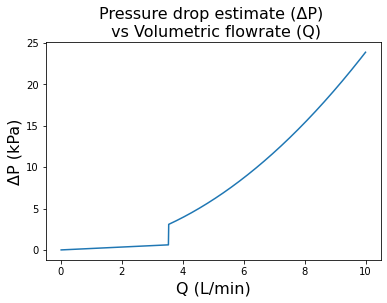

In [5]:
#Plot the calculated pressure drop agains the given volumetric flowrates
plt.plot(Q, ΔP)
plt.title("Pressure drop estimate (ΔP) \n vs Volumetric flowrate (Q)", fontsize=16)
plt.ylabel("ΔP (kPa)", fontsize=16)
plt.xlabel("Q (L/min)", fontsize=16);

### Problem 2 (5 points)

(Continuation of HW 6 Problem 2 and HW 9 Problem 3)

An equation of state (EOS) is used to correlate and predict the relationship between pressure, temperature, and volume for a fluid. The Peng-Robinson EOS--and similar ones--are useful because with one equation you can predict both the vapor and liquid states of a substance. Furthermore, you can predict the _saturation pressure_, or the pressure at which the vapor and liquid are in equilibrium.  In this problem you will do such predictions like you might do in ChEn 373. This is real engineering!

The following will help you understand what equations need to be solved

* The Peng-Robinson EOS is pressure-explicit, meaning it has the form $P_{PR}(V,T)$. However, we often need to solve instead for $V$ as a function of $P$ and $T$. One way to do this inversion is with an equation solver like `fsolve` where you solve the following for $V$: $$P-P_{PR}(V,T) = 0$$ Note that we are comparing a specified pressure $P$ to the EOS value $P_{PR}$ and we want them to match. Python can make this happen by iterating on the value of $V$. To do this it needs a guess value for $V$. If you are trying to find a vapor root or solution, a good guess value is the volume from the ideal gas law: $V_{V,\mathrm{guess}} = RT/P$. If you are trying to find a liquid root a good guess value is $V_{L,\mathrm{guess}}=1.1b$, where $b$ is a molecular size parameter in the Peng-Robinson EOS. 

* Under the set of conditions where both liquid and vapor can coexist, the EOS will have three roots, meaning three $V$ values can produce the same $P_{PR}$ value. The smallest root is for the liquid, the middle root is not used, and the largest root is for the vapor.

* Once you can solve for the vapor and liquid roots, in the form of functions $V_V(P,T)$ and $V_L(P,T)$, then you can use the EOS to solve for the saturation pressure $P_\mathrm{sat}$, which is the exact pressure when the two phases are in equilibrium. The formula is $$P_\mathrm{sat}\cdot \left[ V_V(P_\mathrm{sat},T)-V_L(P_\mathrm{sat},T) \right] - \int_{V_L(P_\mathrm{sat},T)}^{V_V(P_\mathrm{sat},T)} P_{PR}(V,T)~dV = 0$$ 

* In HW 9 Problem 3 you made a function that can give the Peng-Robinson pressure as a function of three molecular constants: $P_c$, $T_c$, and $\omega$; and two variables: absolute temperature $T$ and molar volume $V$. Here we will do calculations on n-hexane for which $P_c=30.25~\mathrm{bar}$, $T_c=507.6~\mathrm{K}$, and $\omega=0.3013$. Use $T=350~\mathrm{K}$ for all calculations.

**(a)** From your calculations make a plot of $P$ (in bar) vs. $V/b$ for the range $1.2\le V/b \le 1000$. Make your plot semilog, with $V/b$ displayed on a log scale. Note that volume is made dimensionless in the plot by dividing by parameter $b$ used in the Peng-Robinsion EOS. Your plot should look like the one below. The big "dip" or "wiggle" in the curve indicates the two-phase region discussed above. 

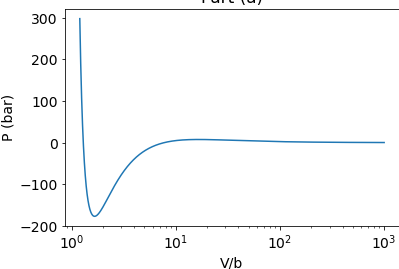

**(b)** Create two functions $V_V(P,T)$ and $V_L(P,T)$ that can solve respectively for the vapor and liquid molar volumes. Use the guess values indicated above and use the `fsolve` function. Evaluate your functions at a pressure of 1 bar where there should be distinct vapor and liquid roots as shown in the part (a) plot. 

**(c)** Now use the EOS and your volume functions to estimate the _saturation pressure_ (in bar) as discussed above. Compare your estimate to the experimental value 0f $1.296~\mathrm{bar}$.


In [6]:
# constants for n-hexane
R   = 8.31446                                              # gas constant (kg*m^2)/(K*mol*s^2)
P_c = 30.250*u.bar_to_pa                                   # critical pressure (Pa)
T_c = 507.6                                                # critical temperature (K)
ω   = 0.3013                                               # acentric factor

# Peng Robinson constants
a   = 0.457236 * R**2 * T_c**2 / P_c                       # (kg/(m*s**2) * (m^3/mol)^2)
b   = 0.0777961 * R * T_c / P_c                            # (m^3/mol)

# environmental parameters
T   = 350                                                  # ambient temperature (K)

In [7]:
def Peng_Robinson_Pressure(V, T):                                                                    # V: m^3/mol, T: K
    κ = 0.37464 + 1.54226 * ω - 0.26992 * ω**2                                                       # (unitless)
    α = (1 + κ - κ * (T/T_c)**0.5)**2                                                                # (unitless)
    return R*T/(V-b) - a*α/(V**2 + 2*V*b - b**2)                                                     # Peng-Robinson pressure (Pa)

def Peng_Robinson_Volume_Vapor(P, T):                                                                # P: Pa, T: K
    V_vapor_guess = R*T/P                                                                            # Initial guess (m^3/mol)
    return fsolve(lambda V, T: P - Peng_Robinson_Pressure(V, T), V_vapor_guess, args=(T))[0]         # m^3/mol

def Peng_Robinson_Volume_Liquid(P, T):                                                               # P: Pa, T: K
    V_liquid_guess = 1.1*b                                                                           # Initial guess (m^3/mol)
    return fsolve(lambda V, T: P - Peng_Robinson_Pressure(V, T), V_liquid_guess, args=(T))[0]        # m^3/mol

In [8]:
V_by_b = np.logspace(0.079181245, 3, 1000)                 # (unitless)
P_pa   = Peng_Robinson_Pressure(V_by_b*b, T)               # (Pa)
P_bar  = P_pa/u.bar_to_pa                                  # (bar)

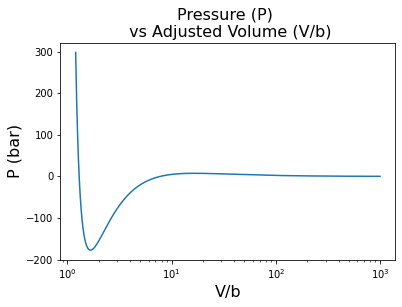

In [9]:
# Part (a) - Plotting P vs V/b

plt.plot(V_by_b, P_bar)
plt.title("Pressure (P) \n vs Adjusted Volume (V/b)", fontsize=16)
plt.xscale("log")
plt.ylabel("P (bar)", fontsize=16)
plt.xlabel("V/b", fontsize=16);

In [10]:
# Part (b) - Calculating Peng-Robinson estimates for the molar volumes at 1 bar and 350 K.

print("The molar volumes of n-hexane at a pressure of 1 bar are {L:.2f} L/mol (liquid) and {V:.2f} L/mol (vapor).".format(
    L = Peng_Robinson_Volume_Liquid(u.bar_to_pa, T)*1000,
    V = Peng_Robinson_Volume_Vapor(u.bar_to_pa, T)*1000
))

The molar volumes of n-hexane at a pressure of 1 bar are 0.14 L/mol (liquid) and 27.98 L/mol (vapor).


In [11]:
exp_P_sat_bar = 1.296                                            # bar
P_sat_bar = fsolve(lambda P_sat: P_sat*(Peng_Robinson_Volume_Vapor(P_sat, T) - Peng_Robinson_Volume_Liquid(P_sat, T))
                   - quad(Peng_Robinson_Pressure, Peng_Robinson_Volume_Liquid(P_sat, T), Peng_Robinson_Volume_Vapor(P_sat, T), args=(T))[0], u.bar_to_pa)[0]/u.bar_to_pa
print("The saturation pressure of n-hexane at a temperature of {T} K as determined by the Peng-Robinson equation is {PP:.3f} bar, compared to the experimentally determined value of {EP:.3f} bar".format(
    T = T,
    PP = P_sat_bar,
    EP = exp_P_sat_bar
))

The saturation pressure of n-hexane at a temperature of 350 K as determined by the Peng-Robinson equation is 1.290 bar, compared to the experimentally determined value of 1.296 bar
